# Integrated gradients

In [6]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import inspect
import os

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Reza's code
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/UniPassau/multimedia_retrieval/covid19_classification/model/save_at_10.h5')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
def load_labels(file_path):
  labels_file = file_path
  with open(labels_file) as reader:
    f = reader.read()
    labels = f.splitlines()
  return np.array(labels)

In [10]:
# imagenet_labels = load_imagenet_labels('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
class_labels = load_labels('/content/drive/MyDrive/UniPassau/multimedia_retrieval/covid19_classification/model/output_labels.txt')

In [11]:
print(class_labels)

['COVID' 'Normal' 'Viral Pneumonia']


### Load and preprocess images with `tf.image`


In [12]:
def read_image(file_name):
  image = tf.io.read_file(file_name)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize_with_pad(image, target_height=300, target_width=300)
  return image

In [13]:
img_paths = {
    
    'COVID': '/content/drive/MyDrive/UniPassau/multimedia_retrieval/covid19_classification/data/COVID-19_Radiography_Dataset/COVID/COVID-10.png',
    'Normal': '/content/drive/MyDrive/UniPassau/multimedia_retrieval/covid19_classification/data/COVID-19_Radiography_Dataset/Normal/Normal-10.png',
    'Pneumonia': '/content/drive/MyDrive/UniPassau/multimedia_retrieval/covid19_classification/data/COVID-19_Radiography_Dataset/Viral Pneumonia/Viral Pneumonia-10.png'
}

img_name_tensors = {name: read_image(img_path) for (name, img_path) in img_paths.items()}

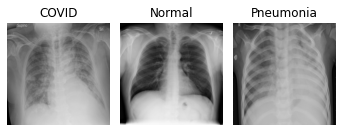

In [115]:
plt.figure(figsize=(8, 8))
for n, (name, img_tensors) in enumerate(img_name_tensors.items()):
  ax = plt.subplot(1, 5, n+1)
  ax.imshow(img_tensors)
  ax.set_title(name)
  ax.axis('off')
plt.tight_layout()

In [88]:
def top_k_predictions(img, k=3):
  image_batch = tf.expand_dims(img, 0)
  predictions = model(image_batch)
  probs = tf.nn.softmax(predictions, axis=-1)
  top_probs, top_idxs = tf.math.top_k(input=probs, k=k)
  top_labels = class_labels[tuple(top_idxs)]
  return top_labels, top_probs[0]

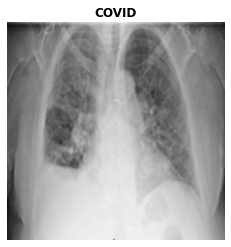

COVID: 57.6%
Viral Pneumonia: 21.2%
Normal: 21.2%


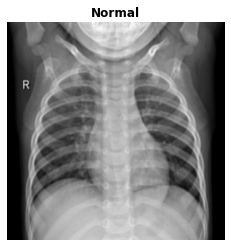

Normal: 57.6%
Viral Pneumonia: 21.2%
COVID: 21.2%


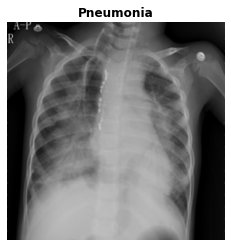

Viral Pneumonia: 57.6%
COVID: 21.2%
Normal: 21.2%


In [89]:
for (name, img_tensor) in img_name_tensors.items():
  plt.imshow(img_tensor)
  plt.title(name, fontweight='bold')
  plt.axis('off')
  plt.show()

  pred_label, pred_prob = top_k_predictions(img_tensor)
  for label, prob in zip(pred_label, pred_prob):
    print(f'{label}: {prob:0.1%}')

## Calculate Integrated Gradients

In [14]:
baseline = tf.zeros(shape=(300,300,3))

In [15]:
def interpolate_images(baseline,
                       image,
                       alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(image, axis=0)
  delta = input_x - baseline_x
  images = baseline_x +  alphas_x * delta
  return images

In [16]:
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1) # Generate m_steps intervals for integral_approximation() below.

In [18]:
interpolated_images = interpolate_images(
    baseline=baseline,
    image=img_name_tensors['COVID'],
    alphas=alphas)

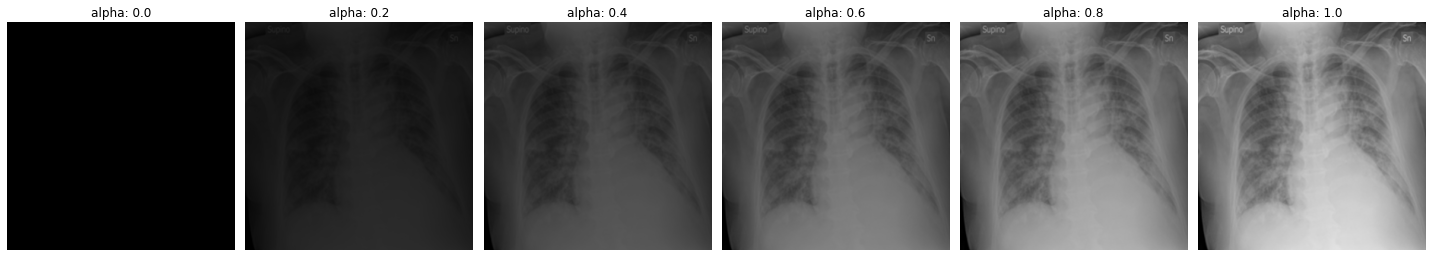

In [19]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image)
  plt.axis('off')

plt.tight_layout();

In [92]:
def compute_gradients(images, target_class_idx):
  with tf.GradientTape() as tape:
    tape.watch(images)
    logits = model(images)
    probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
  return tape.gradient(probs, images)

In [93]:
def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients

In [94]:
@tf.function
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=8):
  # 1. Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

  # Initialize TensorArray outside loop to collect gradients.    
  gradient_batches = tf.TensorArray(tf.float32, size=m_steps+1)
    
  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    # 2. Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)

    # 3. Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)
    
    # Write batch indices and gradients to extend TensorArray.
    gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch)    
  
  # Stack path gradients together row-wise into single tensor.
  total_gradients = gradient_batches.stack()

  # 4. Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  # 5. Scale integrated gradients with respect to input.
  integrated_gradients = (image - baseline) * avg_gradients

  return integrated_gradients

In [112]:
def plot_img_attributions(baseline,
                          image,
                          target_class_idx,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):

  attributions = integrated_gradients(baseline=baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      m_steps=m_steps)

  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.
  attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

  fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

  axs[0, 0].set_title('Baseline image')
  axs[0, 0].imshow(baseline)
  axs[0, 0].axis('off')

  axs[0, 1].set_title('Original image')
  axs[0, 1].imshow(image)
  axs[0, 1].axis('off')

  axs[1, 0].set_title('Attribution mask')
  axs[1, 0].imshow(attribution_mask, cmap=cmap)
  axs[1, 0].axis('off')

  axs[1, 1].set_title('Overlay')
  axs[1, 1].imshow(attribution_mask, cmap=cmap)
  axs[1, 1].imshow(image, alpha=overlay_alpha)
  axs[1, 1].axis('off')

  plt.tight_layout()
  return fig

In [ ]:
_ = plot_img_attributions(image=img_name_tensors['COVID'],
                          baseline=baseline,
                          target_class_idx=0,
                          m_steps=240,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)

In [ ]:
_ = plot_img_attributions(image=img_name_tensors['Normal'],
                          baseline=baseline,
                          target_class_idx=1,
                          m_steps=240,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)

In [ ]:
_ = plot_img_attributions(image=img_name_tensors['COVID'],
                          baseline=baseline,
                          target_class_idx=0,
                          m_steps=55,
                          cmap=plt.cm.viridis,
                          overlay_alpha=0.5)

In [ ]:
for i in range (1,100,3):

  img_paths = {
      
      'COVID': '/content/drive/MyDrive/UniPassau/multimedia_retrieval/covid19_classification/data/COVID-19_Radiography_Dataset/COVID/COVID-{}.png'.format(i),
      'Normal': '/content/drive/MyDrive/UniPassau/multimedia_retrieval/covid19_classification/data/COVID-19_Radiography_Dataset/Normal/Normal-{}.png'.format(i),
      'Pneumonia': '/content/drive/MyDrive/UniPassau/multimedia_retrieval/covid19_classification/data/COVID-19_Radiography_Dataset/Viral Pneumonia/Viral Pneumonia-{}.png'.format(i)
  }

  img_name_tensors = {name: read_image(img_path) for (name, img_path) in img_paths.items()}

  covid_fig = plot_img_attributions(image=img_name_tensors['COVID'],
                            baseline=baseline,
                            target_class_idx=0,
                            m_steps=240,
                            cmap=plt.cm.inferno,
                            overlay_alpha=0.4)
  covid_fig.savefig('/content/drive/MyDrive/UniPassau/multimedia_retrieval/covid19_classification/results/COVID/covid_fig_{}.png'.format(i))

  normal_fig = plot_img_attributions(image=img_name_tensors['Normal'],
                            baseline=baseline,
                            target_class_idx=1,
                            m_steps=240,
                            cmap=plt.cm.inferno,
                            overlay_alpha=0.4)
  normal_fig.savefig('/content/drive/MyDrive/UniPassau/multimedia_retrieval/covid19_classification/results/Normal/normal_fig_{}.png'.format(i))

  pneumonia_fig = plot_img_attributions(image=img_name_tensors['Pneumonia'],
                            baseline=baseline,
                            target_class_idx=2,
                            m_steps=240,
                            cmap=plt.cm.inferno,
                            overlay_alpha=0.4)
  pneumonia_fig.savefig('/content/drive/MyDrive/UniPassau/multimedia_retrieval/covid19_classification/results/Pneumonia/pneumonia_fig_{}.png'.format(i))
